# Description

This Spark program performs churn prediction using two classification models, namely Random Forest and Logistic Regression prediction models.

## Import libraries

In [39]:
import pandas as pd
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from functools import reduce 

from pyspark.sql.types import IntegerType, StringType, DoubleType, StructType, StructField
from pyspark.sql.functions import udf, col

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

%matplotlib inline

## Import data

In [3]:
schemaData = StructType([StructField('AccountLength', IntegerType(), True),
                     StructField('VMailMessage', IntegerType(), True),
                     StructField('DayMins', DoubleType(), True),
                     StructField('EveMins', DoubleType(), True),
                     StructField('NightMins', DoubleType(), True),
                     StructField('IntlMins', DoubleType(), True),
                       StructField('CustServCalls', IntegerType(), True),
                       StructField('Churn', IntegerType(), True),
                       StructField('IntlPlan', IntegerType(), True),
                        StructField('VMailPlan', IntegerType(), True),
                        StructField('DayCalls', IntegerType(), True),
                        StructField('DayCharge', DoubleType(), True),
                        StructField('EveCalls', IntegerType(), True),
                        StructField('EveCharge', DoubleType(), True),
                        StructField('NightCalls', IntegerType(), True),
                        StructField('NightCharge', DoubleType(), True),
                        StructField('IntlCalls', IntegerType(), True),
                        StructField('IntlCharge', DoubleType(), True),
                        StructField('State', StringType(), True),
                        StructField('AreaCode', IntegerType(), True),
                        StructField('Phone', StringType(), True)])

In [4]:
data = sqlContext.read.load('/user/ebisa/Churn.csv', 
                          delimiter=';',
                          format='com.databricks.spark.csv', 
                          header='true', 
                          schema=schemaData,
                           inferSchema='false')

### Distribution of the churn

As can be seen below, the data is skewed in terms of the number of churning and non-churning customers

In [5]:
numbRecords = data.count()
%time churnDist = data.groupBy('Churn').count().toPandas()
churnDist['percentage'] = 100*churnDist['count']/numbRecords
churnDist

CPU times: user 6 ms, sys: 10 ms, total: 16 ms
Wall time: 4.49 s


,Churn,count,percentage
0,0,2850,85.508551
1,1,483,14.491449


### Distribution of some of the features

#### Distribution of AccountLength, which is the number of days the account has been a customer

In [6]:
data.describe('AccountLength').show()

+-------+------------------+
|summary|     AccountLength|
+-------+------------------+
|  count|              3333|
|   mean|101.06480648064806|
| stddev|39.822105928595604|
|    min|                 1|
|    max|               243|
+-------+------------------+



In [7]:
al = data.describe('AccountLength').rdd.collectAsMap()
print('Average AccountLength = %d months and %d days' % (int(float(al['mean'])/30), int(float(al['mean']))%30) )
print('Maximum AccountLength = %d months and %d days' % (int(float(al['max'])/30), int(float(al['max']))%30) )

Average AccountLength = 3 months and 11 days
Maximum AccountLength = 8 months and 3 days


#### The distribution of the DayMins which represents the total day-time call duration in minutes. 

In [8]:
data.describe('DayMins').show()

+-------+------------------+
|summary|           DayMins|
+-------+------------------+
|  count|              3333|
|   mean|179.77509750975088|
| stddev| 54.46738920237139|
|    min|               0.0|
|    max|             350.8|
+-------+------------------+



In [9]:
dm = data.describe('DayMins').rdd.collectAsMap()
print('Average DayMins = %d hours and %d minutes' % (int(float(dm['mean'])/60), int(float(dm['mean']))%60) )
print('Maximum DayMins = %d hours and %d minutes' % (int(float(dm['max'])/30), int(float(dm['max']))%60) )

Average DayMins = 2 hours and 59 minutes
Maximum DayMins = 11 hours and 50 minutes


#### Number of distinct states

In [10]:
data.select('State').distinct().count()

51

### Visualization of some of the features against the churn 

In [11]:
dataPD = data.toPandas()

#### The distribution of DayMins against DayCharge

Below, we can observe that the call duration and the call charge are linearly related, as expected.

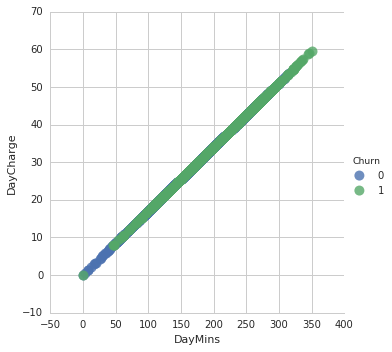

In [12]:
sns.lmplot('DayMins', 'DayCharge', 
           data=dataPD, 
           fit_reg=False, 
           hue="Churn",  
           scatter_kws={"marker": "D", "s": 100})

#### As shown below, the ranges of DayMins of both the churning and non-churning groups overlap.

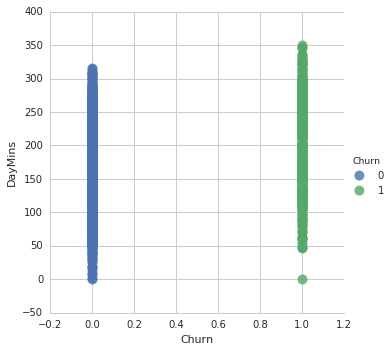

In [13]:
sns.lmplot('Churn', 'DayMins', 
           data=dataPD, 
           fit_reg=False, 
           hue="Churn",  
           scatter_kws={"marker": "D", "s": 100})

#### The ranges of AccountLengrth also overlap for the two classes

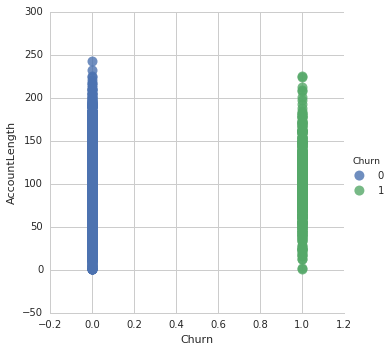

In [14]:
sns.lmplot('Churn', 'AccountLength',  
           data=dataPD, 
           fit_reg=False, 
           hue="Churn",  
           scatter_kws={"marker": "D", "s": 100})

## Compute relevant features

Here we compute new features that represent per-minute call rates for the three periods: day, evening, and night

In [15]:
def takeRatio(a,b):
    if (b>0):
        return float(a)/b
    else:
        return a
computeRatio = udf(takeRatio, DoubleType())

In [16]:
data = data.withColumn('dayRate', computeRatio(data.DayCharge, data.DayMins))\
            .withColumn('eveRate', computeRatio(data.EveCharge, data.EveMins))\
            .withColumn('nightRate', computeRatio(data.NightCharge, data.NightMins))\
            .withColumn('intlRate', computeRatio(data.IntlCharge, data.IntlMins))

In [17]:
data.describe('dayRate').show()

+-------+--------------------+
|summary|             dayRate|
+-------+--------------------+
|  count|                3333|
|   mean| 0.16990122219978002|
| stddev|0.004163887265810569|
|    min|                 0.0|
|    max| 0.17051282051282052|
+-------+--------------------+



## Transform categorical columns into labeled indices

In [18]:
si_label = StringIndexer(inputCol="Churn", outputCol="label", handleInvalid="skip")
si_intPlan = StringIndexer(inputCol="IntlPlan", outputCol="IP", handleInvalid="skip")
si_vmailPlan = StringIndexer(inputCol="VMailPlan", outputCol="VP", handleInvalid="skip")
si_State = StringIndexer(inputCol="State", outputCol="ST", handleInvalid="skip")
pipeline = Pipeline(stages=[si_label, si_intPlan, si_vmailPlan, si_State])

In [19]:
stringIndexedData = pipeline.fit(data).transform(data)

## Make a vector of columns of the features used in prediction

In [20]:
excludedFeatures = ['Churn', "IntlPlan", "VMailPlan", "State", "AreaCode", "Phone"]
features = [x for x in data.columns if x not in excludedFeatures]

In [21]:
vecAssembler = VectorAssembler(inputCols=features, outputCol="features")
featureAssembled = vecAssembler.transform(stringIndexedData)

## Divide the data into training and test sets

In [22]:
(train, test) = featureAssembled.randomSplit([0.8, 0.2])

In [23]:
train.groupBy('Churn').count().toPandas().head()

,Churn,count
0,0,2234
1,1,386


In [24]:
test.groupBy('Churn').count().toPandas().head()

,Churn,count
0,0,616
1,1,97


## Compensate for the data imbalance between churning and non-churnnig users

In [25]:
def unionAll(*dfs):
    return reduce(DataFrame.unionAll, dfs)

In [26]:
ratio = train.where(train.Churn == 0).count()/train.where(train.Churn == 1).count()
train_1 = train.where(train.Churn == 1)

In [27]:
# append train_1 onto train ratio-1 times to balance between churned and non-churned data
for i in range(0, ratio - 1):
    train = train.unionAll(train_1)

## Build two predictive models and perform cross validation and grid search of parameters for each

Random forest and Logistic regression models are used.

In [40]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=3, maxDepth=4, maxBins=200)
lr = LogisticRegression(maxIter=20, regParam=0.2, elasticNetParam=0.7)

#### Define the grid search parameter values

In [53]:
grid_rf = ParamGridBuilder().addGrid(rf.numTrees, [2, 5, 10])\
                         .addGrid(rf.maxDepth, [2, 5, 10])\
                         .build()
grid_lr = ParamGridBuilder().addGrid(lr.regParam, [0.2, 0.4, 0.8])\
                         .addGrid(lr.elasticNetParam, [0.2, 0.4, 0.8])\
                         .build()

#### Define the evaluator

In [54]:
evaluator = BinaryClassificationEvaluator()

#### Define the cross-validation

Cross validation is performed to limit overfitting to the training set, give an insight on how the model will generalize to an independent test set.

In [55]:
#perform a cross validator
cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=grid_rf, evaluator=evaluator)
cv_lr = CrossValidator(estimator=lr, estimatorParamMaps=grid_lr, evaluator=evaluator)

#### Train the two models on the training set

In [56]:
model_rf = cv_rf.fit(train)
model_lr = cv_lr.fit(train)

#### Predict on the test set

In [57]:
test_rf = model_rf.transform(test)
test_lr = model_lr.transform(test)

### Evaluate the performance of the model on the test data using both area under ROC and area under PR

As can be seen, the Random Forest model is out performing the Logistic Regression model on both performance measures.

In [62]:
print("Random Forest: Area under ROC = %f" % evaluator.evaluate(test_rf,  {evaluator.metricName: "areaUnderROC"}))
print("Logistic Regression: Area under ROC = %f" % evaluator.evaluate(test_lr ,{evaluator.metricName: "areaUnderROC"}))
print("Random Forest: Area under PR = %f" % evaluator.evaluate(test_rf, {evaluator.metricName: "areaUnderPR"}))
print("Logistic Regression: Area under PR = %f" % evaluator.evaluate(test_lr, {evaluator.metricName: "areaUnderPR"}))

Random Forest: Area under ROC = 0.824031
Logistic Regression: Area under ROC = 0.732494
Random Forest: Area under PR = 0.632395
Logistic Regression: Area under PR = 0.284988
